# Preprocessing of Mouse Organogenesis Spatiotemporal Transcriptomic Atlas (MOSTA)

Data from [[1]](https://doi.org/10.1016/j.cell.2022.04.003) as provided in [MOSTA](https://db.cngb.org/stomics/mosta/), [Mouse_embryo_all_stage.h5ad](https://ftp.cngb.org/pub/SciRAID/stomics/STDS0000058/stomics/Mouse_embryo_all_stage.h5ad)

In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys

In [3]:
from datetime import datetime
import numpy as np
from copy import copy
import pickle as pkl
import glob

import scanpy as sc
import matplotlib.pyplot as plt

In [4]:
import mplscience
mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

## Set parameters

In [5]:
sys.path.insert(
    0, "../../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "space/spatiotemporal"
DATA_DIR = DATA_DIR / "space/spatiotemporal"

from pathlib import Path
DATA_DIR = Path("/cs/labs/mornitzan/zoe.piran/research/projects/moscot_framework_analysis/data/mosta/")

## Preprocess data (all stages)

In [6]:
adata_six = sc.read(DATA_DIR / "Mouse_embryo_all_stage.h5ad")

In [7]:
adata_six.obs["time"] = adata_six.obs["timepoint"].copy()
adata_six.obs["time"] = adata_six.obs["time"].cat.rename_categories(lambda x: float(x.split("E")[1]))
adata_six.obs["time"] = adata_six.obs["time"].astype(float)

In [8]:
adata_six.X = adata_six.layers["count"].copy()

In [9]:
adata = adata_six.copy()

### basic filtering

In [10]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
adata.var["mt"] = adata.var_names.str.startswith("mt-")  # annotate the group of mitochondrial genes as "mt" (#13 genes.. )
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

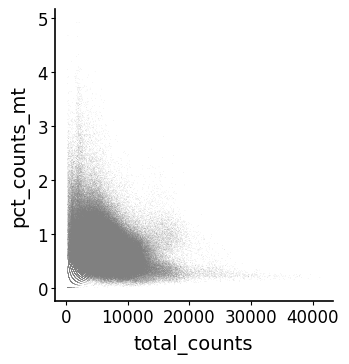

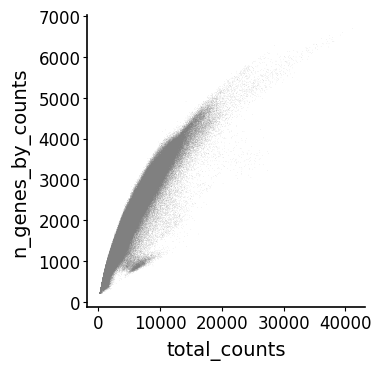

In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [13]:
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000, subset=False, batch_key="timepoint")

In [14]:
sc.pp.normalize_total(adata)

In [15]:
sc.pp.log1p(adata)

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cs/labs/mornitzan/zoe.piran/venvzp/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


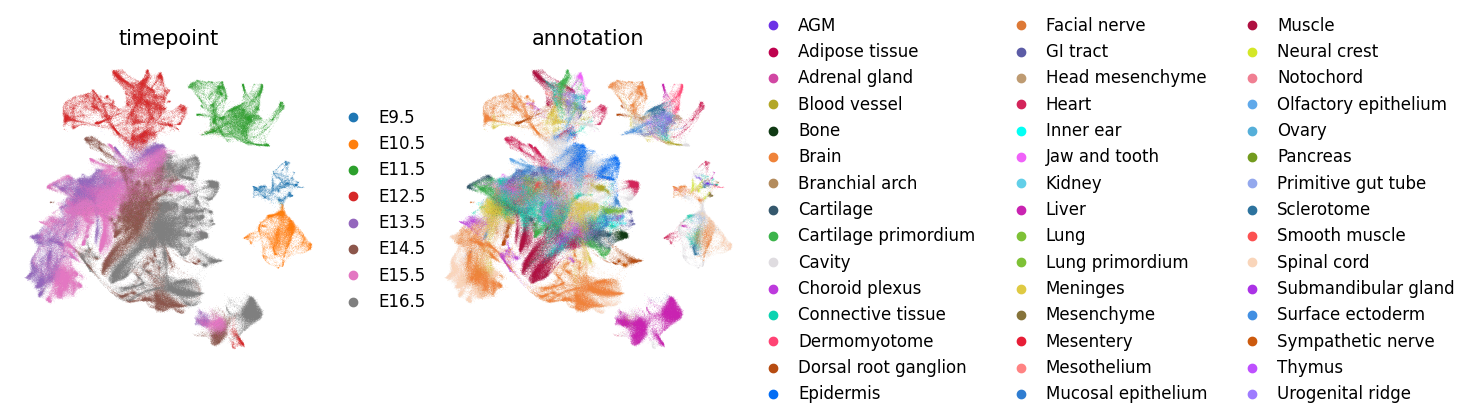

In [17]:
sc.pl.umap(
    adata,
    color=[
        "timepoint",
        "annotation",
    ],
    frameon=False,
    hspace=10,
)
plt.tight_layout()

In [ ]:
adata.write(DATA_DIR / "mouse_embryo_all_stage_renormalized.h5ad")

In [ ]:
adata.obs["time"] = adata.obs["timepoint"].copy()
adata.obs["time"] = adata.obs["time"].cat.rename_categories(lambda x: x.split("E")[1]).astype(float)
adata.obs["time"] = adata.obs["time"].astype("category")
    
tps_numeric = np.unique(adata.obs["time"])
tps_couple = [[i, i+1] for i in tps_numeric[:-1]]

for tps_c in tps_couple:
    start, end = tps_c
    adata_c = adata_six[adata_six.obs["time"].isin(tps_c)].copy()
    sc.pp.pca(adata_c, use_highly_variable=True)
    adata_c.obsm["X_pca_30"] = adata_c.obsm["X_pca"][:, :30]
        
    adata_c.obs["transition"] = adata_c.obs_names
    adata_c.obs.loc[adata_c.obs["time"].isin([start]), "transition"] = \
        adata_c[adata_c.obs["time"].isin([start])].obs["annotation"]
    adata_c.obs["transition"] = adata_c.obs["transition"].astype("category")
    del adata_c.layers
    start_str = str(start).replace(".", "_")
    end_str = str(end).replace(".", "_")
    print(f"saving adata to `mouse_embryo_{start_str}_{end_str}_renormalized.h5ad`")
    adata_c.write(DATA_DIR / f"mouse_embryo_{start_str}_{end_str}_renormalized.h5ad")

[[1] Ao Chen, Sha Liao, Mengnan Cheng, Kailong Ma, Liang Wu, Yiwei Lai, Xiaojie Qiu et al. "Spatiotemporal transcriptomic atlas of mouse organogenesis using DNA nanoball-patterned arrays." Cell (2022)](https://doi.org/10.1016/j.cell.2022.04.003)